<table>
  <tr>
    <td><img src="https://github.com/rvss-australia/RVSS/blob/main/Pics/RVSS-logo-col.med.jpg?raw=1" width="400"></td>
    <td><div align="left"><font size="30">Finding Stop Sign</font></div></td>
  </tr>
</table>

(c) Jason Abi Chebli 

Testing Stop Sign Stuff

## Configuring the Jupyter environment


In [14]:
from machinevisiontoolbox import Image
from spatialmath import SE3
from spatialmath import base
import cv2
import torch
import numpy as np
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from PIL import Image as PILImage 
from skimage import measure

***

# Import the image and do Colour Thresholding


In [63]:
# Read the image using OpenCV
image_path = r'C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\stopSign5\0001320.00.jpg'
im = cv2.imread(image_path)

# OpenCV reads the image in BGR format by default, so we need to convert it to RGB
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

# Image Preprocessing (Cropping the image)
im = im[120:, :, :]

# Convert image from RGB to HSV (since OpenCV uses BGR, we should convert from BGR, not RGB)
hsv_im = cv2.cvtColor(im, cv2.COLOR_RGB2HSV)

lower_red1 = np.array([0, 125, 75])  
upper_red1 = np.array([1, 255, 255]) 

lower_red2 = np.array([160, 120, 70])
upper_red2 = np.array([180, 255, 255])


# Create masks for both red ranges
mask1 = cv2.inRange(hsv_im, lower_red1, upper_red1)
mask2 = cv2.inRange(hsv_im, lower_red2, upper_red2)

# Combine both masks
mask = cv2.bitwise_or(mask1, mask2)

# Apply the mask to extract red regions
result = cv2.bitwise_and(im, im, mask=mask)

# Show Color Threshold Image

True

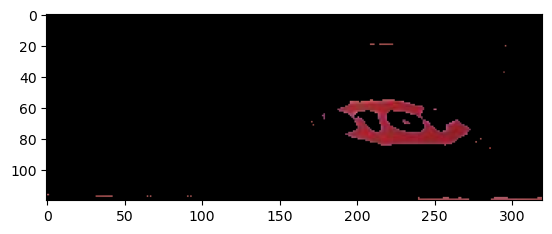

In [64]:
plt.imshow(result)

# Save image 
save_path = r'C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\red2_image.png'
cv2.imwrite(save_path, result)

# Do Blop Analysis

The `blobs` object can describe a number of blobs, and in this case there are

In [43]:
# Convert mask to binary (this step ensures 0 and 255 pixel values)
binary_im = np.where(mask > 0, 255, 0).astype(np.uint8)

# Calculate the padding required
padding_height = 236 - binary_im.shape[0]

if padding_height > 0:
    # Create the padding (black pixels)
    padding = np.zeros((padding_height, binary_im.shape[1]), dtype=np.uint8)
    # Pad the image vertically (at the top)
    padded_im = np.vstack([padding, binary_im])
else:
    padded_im = np.vstack([binary_im])


#save_path = r'C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\binary_image.png'
#cv2.imwrite(save_path, padded_im)


# Determine the blobs
im_binary = Image(padded_im)
blobs = im_binary.blobs()
print(blobs)


# # Convert mask to binary (this step ensures 0 and 255 pixel values)
# binary_im = (mask > 0).astype(np.uint8) * 255

# save_path = r'C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\binary_image.jpg'
# cv2.imwrite(save_path, binary_im)

# # Determine the blobs
# im_binary = Image.Read(save_path)
# blobs = im_binary.blobs()
# print(blobs)
# im_binary.disp()

# regions = measure.regionprops(im_binary)

# for region in regions:
#     print(f"Label: {region.label}")
#     print(f"Area: {region.area}")
#     print(f"Centroid: {region.centroid}")
#     print(f"Bounding Box: {region.bbox}")
#     print(f"Perimeter: {region.perimeter}")
#     print(f"Solidity: {region.solidity}")
# # print(im_binary)
# # blobs = im_binary.blobs()
# #print(blobs)

# # # Check the properties of the blobs
# # for i in range(len(blobs)):
# #     cx, cy = blobs[i].centroid
# #     ax, ay = blobs[i].area
# #     bx, by = blobs[i].bbox
# #     print(f"Centroid {i+1}: ({cx}, {cy})")
# #     print(f"Area {i+1}: ({ax}, {ay})")
# #     print(f"Bounding Box {i+1}: ({bx}, {by})")

KeyboardInterrupt: 

blobs.  The background is also a blob, a black blob, but here we are ignoring that.

This object can be indexed or sliced just like a list.  Each element has a number of properties such as its centroid (centre of mass)

In [53]:
read_path = r'C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\red2_image.png'

# Determine the blobs
im_binary = Image.Read(read_path)
blobs = im_binary.blobs()
print(blobs)

im_binary.disp(block=None)
blobs.plot_box(color='yellow', linewidth=2)
blobs.plot_centroid()

KeyboardInterrupt: 

# Detect Stop Sign Function

In [39]:
def stop_sign_detection(im):
    ### ---- Detect Stop Sign ---- ###
    
    # Convert the image to HSV color space for color segmentation
    hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)


    # Define refined HSV ranges for more precise pure red detection
    lower_red1 = np.array([0, 125, 75])  # Higher saturation and brightness to exclude orange
    upper_red1 = np.array([1, 255, 255])


    lower_red2 = np.array([160, 120, 70])  # Focus on the deeper red tones
    upper_red2 = np.array([180, 255, 255])


    # Create masks for the refined red range
    mask1 = cv2.inRange(hsv, lower_red1, upper_red1)
    mask2 = cv2.inRange(hsv, lower_red2, upper_red2)
    red_mask = cv2.bitwise_or(mask1, mask2)


    # Apply the red mask to the original image
    red_filtered = cv2.bitwise_and(im, im, mask=red_mask)

    # OPTIONAL: Remove small blobs/noise using morphological operations
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    red_mask_cleaned = cv2.morphologyEx(red_mask, cv2.MORPH_OPEN, kernel)

    # Find contours on the red mask
    contours, _ = cv2.findContours(red_mask_cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Copy the original image to draw bounding boxes
    image_with_boxes = im.copy()

    bottom_line_list = []

    # Loop through the contours and draw bounding boxes
    for contour in contours:
        # Filter by contour area to remove noise
        area = cv2.contourArea(contour)
        if area > 500:  # Adjust this threshold as needed
            # Get bounding box coordinates
            x, y, w, h = cv2.boundingRect(contour)
            bottom_line_list.append(y+h)    
            
            # Draw the bounding box
            cv2.rectangle(image_with_boxes, (x, y), (x + w, y + h), (0, 255, 0), 2)
    
    # Determine the lowest boundary line
    if len(bottom_line_list) > 0:
        if max(bottom_line_list) > 85:
            return True, red_mask_cleaned 
        else:
            return False, red_mask_cleaned
    else:
        return False, red_mask_cleaned

In [22]:
import os
import cv2
import numpy as np


# Run through the different photos and see if it stops

In [40]:
import os
import cv2
import numpy as np


# Set the path to the folder containing the photos
folder_path = r"C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\stopSign5"

list_stops = []
bottom_line_list = []
red_masks = []

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you can extend this list based on your image types)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
        
        # Read the image using OpenCV
        im = cv2.imread(file_path)
        
        # Crop the image (from row 120 onward)
        im = im[120:, :, :]

        # Call the stop_sign_detection function
        val, red_mask = stop_sign_detection(im)
        bottom_line_list += [val] 
        
        if val:
            list_stops += [filename]
            red_masks.append(red_mask)  # Use append to add the mask to the list

    
    #print("The number of stop signs stopped at " + len(list_stops))

print(list_stops)
print(len(list_stops))
        
        

['000031-0.20.jpg', '000032-0.20.jpg', '000033-0.20.jpg', '0001330.00.jpg', '0001340.00.jpg', '0001350.00.jpg', '0001360.00.jpg', '0001370.00.jpg', '0001380.00.jpg', '0001390.00.jpg', '0001400.00.jpg', '0002180.10.jpg', '0002190.10.jpg', '0002200.10.jpg', '0002210.00.jpg', '000222-0.10.jpg', '000223-0.10.jpg']
17


where the first row is the u-axis range, and the second row is the v-axis range.  Alternatively we can consider the columns: the first column is the top-left coordinate and the second column is the bottom-right coordinate.

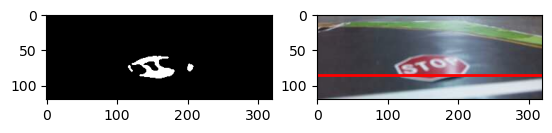

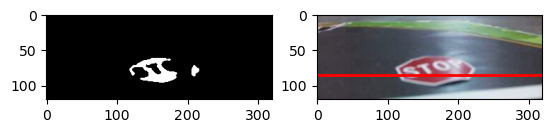

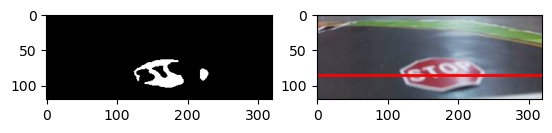

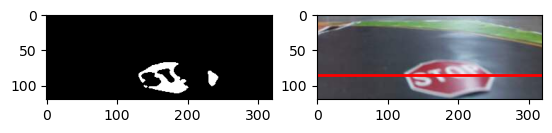

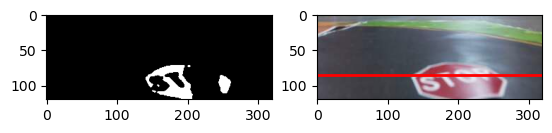

KeyboardInterrupt: Interrupted by user

In [43]:
# Display images with a line at pixel y = 70 one at a time
i = 0 

for filename in list_stops:
    # Construct the full file path again
    file_path = os.path.join(folder_path, filename)

    # Read the image
    im = cv2.imread(file_path)

    # Crop the image (from row 120 onward)
    im = im[120:, :, :]

    # Convert from BGR to RGB (matplotlib expects RGB)
    im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.subplot(1, 2, 1)
    plt.imshow(red_masks[i], cmap='gray')

    plt.subplot(1, 2, 2)
    plt.imshow(im_rgb)
    # Add a horizontal line at y = 70 (adjusting for the cropped image)
    plt.axhline(y=85, color='r', linestyle='-', linewidth=2)
    

    # Display the image
    plt.show()

    # Wait for the user to close the image before showing the next one
    input("Press Enter to show the next image...")

    i += 1

which depicts and labels each blob.  We also marked the centroids.

which add a marker to the plot above.

Now we will load a more complex image that has blobs with holes in them

In [ ]:
import os
import cv2
import numpy as np


# Set the path to the folder containing the photos
folder_path = r"C:\Jason\RVSS\Workshop Repo\RVSS_Need4Speed\data\stopSign5"

list_stops = []
bottom_line_list = []
red_masks = []

saturation_scale = 1.5

# Loop through all files in the folder
for filename in os.listdir(folder_path):
    # Check if the file is an image (you can extend this list based on your image types)
    if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif')):
        # Construct the full file path
        file_path = os.path.join(folder_path, filename)
               
        # Read the image using OpenCV
        im = cv2.imread(file_path)
        
        # Crop the image (from row 120 onward)
        im = im[120:, :, :]

        ####### -------------- INCREASE CONTRAST -------------- #######

        # Convert to HSV color space
        hsv = cv2.cvtColor(im, cv2.COLOR_BGR2HSV)

        # Split the HSV channels
        h, s, v = cv2.split(hsv)


        # Increase saturation
        s = np.clip(s * saturation_scale, 0, 255).astype(np.uint8)

        # Merge back and convert to BGR
        hsv_enhanced = cv2.merge((h, s, v))
        im = cv2.cvtColor(hsv_enhanced, cv2.COLOR_HSV2BGR)

        cv2.imshow("Saturation Adjusted Image", im)
        cv2.waitKey(0)

        # Call the stop_sign_detection function
        val, red_mask = stop_sign_detection(im)
        bottom_line_list += [val] 
        
        if val:
            list_stops += [filename]
            red_masks.append(red_mask)  # Use append to add the mask to the list

    
    #print("The number of stop signs stopped at " + len(list_stops))

print(list_stops)
print(len(list_stops))
        
        

There are 10 blobs here and we can display their parameters

In [10]:
blobs = multi.blobs()
len(blobs)

10

In [11]:
print(blobs)

┌────┬────────┬───────────────┬──────────┬───────┬────────┬────────┬─────────┬────────┐
│ id │ parent │      centroid │     area │ touch │  perim │ circul │  orient │ aspect │
├────┼────────┼───────────────┼──────────┼───────┼────────┼────────┼─────────┼────────┤
│  0 │     -1 │  907.9, 735.1 │ 1.94e+05 │ False │ 2219.0 │  0.551 │ -103.6° │  0.814 │
│  1 │      0 │ 1025.0, 813.7 │ 1.06e+05 │ False │ 1386.9 │  0.770 │  -90.0° │  0.802 │
│  2 │      1 │  938.1, 855.2 │ 1.72e+04 │ False │  489.7 │  1.005 │  -12.5° │  0.945 │
│  3 │      1 │  988.1, 697.2 │ 1.21e+04 │ False │  411.5 │  0.999 │ -102.8° │  0.919 │
│  4 │      0 │  846.0, 511.7 │ 1.75e+04 │ False │  495.9 │  0.996 │  -90.1° │  0.871 │
│  5 │     -1 │  291.7, 377.8 │  1.7e+05 │ False │ 1711.6 │  0.811 │ -102.9° │  0.775 │
│  6 │      5 │  312.7, 472.1 │ 1.75e+04 │ False │  494.5 │  1.001 │  -90.2° │   0.87 │
│  7 │      5 │  241.9, 245.0 │ 1.75e+04 │ False │  495.9 │  0.996 │  -90.1° │  0.871 │
│  8 │     -1 │ 1228.0, 254.3 │ 

We note that this time some of the blobs have a parent that is not -1.  Looking at the figure it's clear that we have some blob hierarchy information

In [12]:
blobs[5].parent

In [13]:
blobs[5].children

[Blob[6](area=1.8e+04, color=255, parent=5)],
 Blob[7](area=1.8e+04, color=255, parent=5)]]

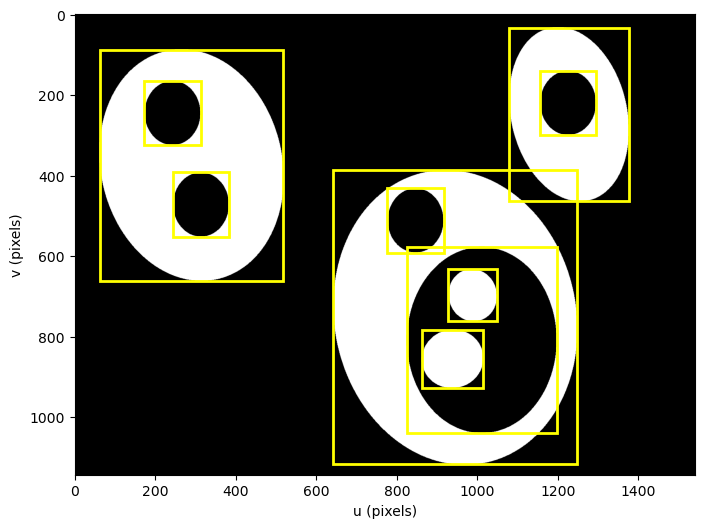

In [14]:
multi.disp(block=None)
blobs.plot_box(color='yellow', linewidth=2)